## Investigating effects of job dissatisfaction on resignations

This project is exploring survey data from employees from the Department of Education, Training and Employment (DETE) and the Technical and Further Education (TAFE) in Australia. The goal is to find out whether people who leave their jobs are dissatisfied with their jobs

In [112]:
import pandas as pd
import numpy as np
%matplotlib inline

dete_survey= pd.read_csv("dete_survey.csv",na_values= "Not Stated")
tafe_survey= pd.read_csv("tafe_survey.csv")

# Explring the datasets
# dete_survey.head()
# dete_survey.info()
# tafe_survey.head()
# tafe_survey.info()


In [75]:
dete_survey_updated= dete_survey.drop(dete_survey.columns[28:49], axis=1)
tafe_survey_updated= tafe_survey.drop(tafe_survey.columns[17:66], axis=1)

We removed dataframe columns that we won't work with

In [76]:
dete_survey_updated.columns= dete_survey_updated.columns.str.lower().str.strip().str.replace(" ","_")

mapping= {"Record ID":'id','CESSATION YEAR': 'cease_date', 'Reason for ceasing employment': 'separationtype', 'Gender. What is your Gender?': 'gender', 'CurrentAge. Current Age': 'age', 'Employment Type. Employment Type': 'employment_status', 'Classification. Classification': 'position', 'LengthofServiceOverall. Overall Length of Service at Institute (in years)': 'institute_service'
         }
tafe_survey_updated.rename(columns= mapping, inplace= True)

In [77]:
# dete_survey_updated.head()
# tafe_survey_updated.head()

In [78]:
dete_survey_updated["separationtype"].value_counts()
tafe_survey_updated["separationtype"].value_counts()

dete_resignations= dete_survey_updated[dete_survey_updated["separationtype"].str.contains("Resignation")].copy()
tafe_resignations= tafe_survey_updated[tafe_survey_updated["separationtype"]=="Resignation"].copy()

# tafe_resignations["separationtype"]
# data.loc[data.bidder == 'parakeet2004', 'bidderrate'] = 100


In the previous block, we subset both datasets to ensure that we only have informations on employeees that resigned

In [81]:
# Extract the years and convert them to a float type
dete_resignations['cease_date'] = dete_resignations['cease_date'].str.split('/').str[-1]
dete_resignations['cease_date'] = dete_resignations['cease_date'].astype("float")

# Check the values again and look for outliers
dete_resignations['cease_date'].value_counts()

2013.0    146
2012.0    129
2014.0     22
2010.0      2
2006.0      1
Name: cease_date, dtype: int64

In [82]:
# Check the values again and look for outliers
tafe_resignations['cease_date'].value_counts()
dete_resignations['dete_start_date'].value_counts()

2011.0    116
2012.0     94
2010.0     68
2013.0     55
2009.0      2
Name: cease_date, dtype: int64

In [85]:
### Creating new column to view how many years an employee stayed

In [84]:
dete_resignations["institute_service"]=dete_resignations["cease_date"]-dete_resignations["dete_start_date"] 

In [88]:
tafe_resignations['Contributing Factors. Dissatisfaction'].value_counts()
tafe_resignations['Contributing Factors. Job Dissatisfaction'].value_counts()

-                      270
Job Dissatisfaction     62
Name: Contributing Factors. Job Dissatisfaction, dtype: int64

In [89]:
# Update the values in the contributing factors columns to be either True, False, or NaN
def update_vals(x):
    if x == '-':
        return False
    elif pd.isnull(x):
        return np.nan
    else:
        return True
tafe_resignations['dissatisfied'] = tafe_resignations[['Contributing Factors. Dissatisfaction', 'Contributing Factors. Job Dissatisfaction']].applymap(update_vals).any(1, skipna=False)
tafe_resignations_up = tafe_resignations.copy()

# Check the unique values after the updates
tafe_resignations_up['dissatisfied'].value_counts(dropna=False)

False    241
True      91
NaN        8
Name: dissatisfied, dtype: int64

In [92]:
# Update the values in columns related to dissatisfaction to be either True, False, or NaN
dete_resignations['dissatisfied'] = dete_resignations[['job_dissatisfaction',
       'dissatisfaction_with_the_department', 'physical_work_environment',
       'lack_of_recognition', 'lack_of_job_security', 'work_location',
       'employment_conditions', 'work_life_balance',
       'workload']].any(1, skipna=False)
dete_resignations_up = dete_resignations.copy()
dete_resignations_up['dissatisfied'].value_counts(dropna=False)

False    162
True     149
Name: dissatisfied, dtype: int64

### Combining dataframes
Concataning DETE and TAFE dataframes and getting rid of columns with a lot of null values

In [96]:

dete_resignations_up["institute"]= "DETE"
tafe_resignations_up["institute"]= "TAFE"

combined = pd.concat([dete_resignations_up, tafe_resignations_up], ignore_index=True)
combined_updated= combined.dropna(thresh=500, axis= 1)

### Converting years of service into categories

In [102]:
combined_updated['institute_service_up'] = combined_updated['institute_service'].astype('str').str.extract(r'(\d+)').astype('float')

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':
/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Separating people into categories based off years of service

In [104]:
# Convert years of service to categories
def transform_service(val):
    if val >= 11:
        return "Veteran"
    elif 7 <= val < 11:
        return "Established"
    elif 3 <= val < 7:
        return "Experienced"
    elif pd.isnull(val):
        return np.nan
    else:
        return "New"
combined_updated['service_cat'] = combined_updated['institute_service_up'].apply(transform_service)

# Quick check of the update
combined_updated['service_cat'].value_counts()

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


New            193
Experienced    172
Veteran        136
Established     62
Name: service_cat, dtype: int64

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


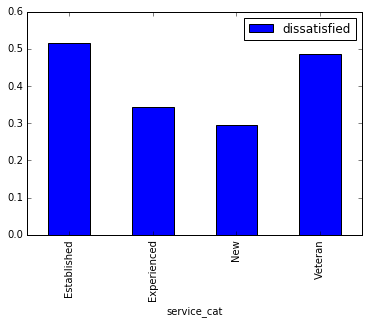

In [114]:
combined_updated["dissatisfied"].value_counts(dropna =False)
# Say missing values are false as those are more common than True values
combined_updated['dissatisfied'] = combined_updated['dissatisfied'].fillna(False)

dis_pct = combined_updated.pivot_table(index='service_cat', values='dissatisfied')
dis_pct.plot(kind="bar")

### Job dissatisfaction seems to be higher among employees who resign after being with te company for a longer time